**PLEASE CLICK FILE + 'SAVE A COPY IN DRIVE' BEFORE GOING ANY FURTHER**

In [ ]:
#@title Run this to import necessary libraries! { display-mode: "form" }
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as F

import string
import unicodedata
import os

from transformers import AutoTokenizer

**Breast cancer diagnostic dataset**

The dataset we will use to train our model is called the Breast Cancer Wisconsin (Diagnostic) Data Set.

Each biopsy sample in the dataset is labeled with an ID number and whether or not the tumor it came from is malignant (1) or benign (0). Each sample also has 10 different features associated with it. In this notebook, we will only be focusing on $Radius$: Average distance from the center of the cell's nucleus to its perimeter.

The paper that first detailed these measurements for this dataset can be found here for more information: https://pdfs.semanticscholar.org/1c4a/4db612212a9d3806a848854d20da9ddd0504.pdf

In [4]:
# FIX THIS
#@title Run this to download your data! { display-mode: "form" }
# Load the data!
import gdown
import pandas as pd
from sklearn import metrics

# gdown.download('https://drive.google.com/uc?id=1grV8hSxULsGvnbwEMPjPaknccfIOlcoB','cancer_data.csv',True);

from google.cloud import storage
def download_public_file(bucket_name, source_blob_name, destination_file_name):
    storage_client = storage.Client.create_anonymous_client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Downloaded public blob {} from bucket {} to {}.".format(
            source_blob_name, bucket.name, destination_file_name
        )
    )

download_public_file('inspirit-ai-data-bucket-1','Data/AI Scholars/Sessions 1 - 5/Session 2b - Logistic Regression/cancer.csv','cancer_data.csv')

data = pd.read_csv('cancer_data.csv')
data['diagnosis'].replace({'M':1, 'B':0}, inplace = True)
data.to_csv('cancer_data.csv')
del data

Downloaded public blob Data/AI Scholars/Sessions 1 - 5/Session 2b - Logistic Regression/cancer.csv from bucket inspirit-ai-data-bucket-1 to cancer_data.csv.


<ipython-input-4-eda381bc80e6>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['diagnosis'].replace({'M':1, 'B':0}, inplace = True)


In [5]:
data_path  = 'cancer_data.csv'

# Use the 'pd.read_csv('file')' function to read in read our data and store it in a variable called 'dataframe'
dataframe = pd.read_csv(data_path)

dataframe = dataframe[['diagnosis', 'perimeter_mean', 'radius_mean', 'texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean']]
dataframe['diagnosis_cat'] = dataframe['diagnosis'].astype('category').map({1: '1 (malignant)', 0: '0 (benign)'})

# We'll use the 'info' method to see the data types of each column
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   diagnosis        569 non-null    int64   
 1   perimeter_mean   569 non-null    float64 
 2   radius_mean      569 non-null    float64 
 3   texture_mean     569 non-null    float64 
 4   area_mean        569 non-null    float64 
 5   smoothness_mean  569 non-null    float64 
 6   concavity_mean   569 non-null    float64 
 7   symmetry_mean    569 non-null    float64 
 8   diagnosis_cat    569 non-null    category
dtypes: category(1), float64(7), int64(1)
memory usage: 36.4 KB


**Data Preprocessing**

We'll split up our data set into groups called 'train' and 'test'. We teach our 'model' the patterns using the train data, but the whole point of machine learning is that our prediction should work on 'unseen' data or 'test' data. Fill in the following function to get our training and testing data! Feel free to refer to the [documentation](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html).

In [7]:
# TODO: Fill in the function!
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=42)

# Linear Regression
Let's start by predicting a diagnosis using a single feature: radius mean. Linear regression is a way to find a straight line that best fits a set of data points. This line helps us understand how one thing (like hours studied) affects another thing (like test scores) and can be used to make predictions based on the data.

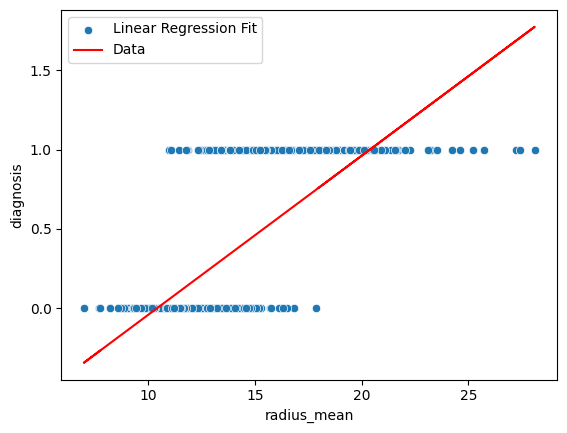

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
# Run this to fit and visualize a linear regression
X,y = dataframe[['radius_mean']], dataframe[['diagnosis']]

model = linear_model.LinearRegression()
model.fit(X, y)
preds = model.predict(X)

sns.scatterplot(x='radius_mean', y='diagnosis', data=dataframe)
plt.plot(X, preds, color='r')
plt.legend(['Linear Regression Fit', 'Data'])

However, you are likely familiar with linear regression being used in the context of predicting continuous values, and this is usually the case! As you can see from our results, the Linear Regression model is not performing too well. Instead, let's use a different but also standard statistical method to predict whether the tumor is benign or malignant.

# Logistic Regression

Logistic regression is a method used to predict the probability of a specific outcome, usually in cases where the result is categorical (e.g., yes/no, pass/fail). Instead of predicting a straight line like linear regression, logistic regression outputs values between 0 and 1 using a curve called the logistic function.

The main difference between the two is their purpose: linear regression predicts continuous values (like height or weight), while logistic regression is used for categorical outcomes. Additionally, linear regression works with a straight-line relationship, whereas logistic regression uses a curve to model probabilities.

In [10]:
X = ['radius_mean']
y = 'diagnosis'

X_train = train_df[X]
print('X_train, our input variables:')
print(X_train.head())
print()

y_train = train_df[y]
print('y_train, our output variable:')
print(y_train.head())

X_test = test_df[X]
y_test = test_df[y]

X_train, our input variables:
     radius_mean
68         9.029
181       21.090
63         9.173
248       10.650
60        10.170

y_train, our output variable:
68     0
181    1
63     0
248    0
60     0
Name: diagnosis, dtype: int64


In [18]:
from sklearn.linear_model import LogisticRegression

# Convert X_train to numerical values (ensure it's numeric)
X_train = pd.to_numeric(train_df['radius_mean'], errors='coerce').values.reshape(-1, 1)
y_train = train_df['diagnosis'].astype('category').cat.codes  # Ensure y_train is numeric

logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_train)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


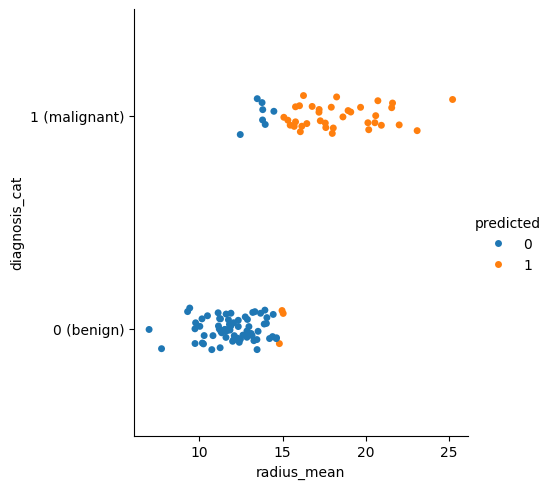

In [21]:
# Make predictions for the test set
y_pred = logreg_model.predict(X_test)

# Assign the predicted values to the test_df
test_df['predicted'] = y_pred

# Plot the data with seaborn
sns.catplot(x='radius_mean', y='diagnosis_cat', hue='predicted', data=test_df, order=['1 (malignant)', '0 (benign)'])


In [23]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy}")


Accuracy: 0.9122807017543859


**MNIST Dataset**

After learning about simple models like linear and logistic regression, it's natural to explore more complex datasets that push these foundational concepts further. One such dataset is MNIST, a widely used collection of handwritten digits labeled from 0 to 9. MNIST is often used as a beginner-friendly introduction to machine learning for tasks like image recognition. Unlike simpler datasets like the Wisconsin biopsy dataset, MNIST requires models to handle higher-dimensional data (28x28 pixel images), meaning we need more complex models to find patterns within the data.


In [ ]:
#@title Run this to download your data! { display-mode: "form" }

from tensorflow.keras.datasets import mnist

In [24]:
#load data
(X_train,y_train),(X_test,y_test)= mnist.load_data()

#Normalize the data
X_train = X_train/255.0
X_test = X_test/255.0

#Flatten the images
X_train = X_train.reshape(-1,28*28)
X_test = X_test.reshape(-1,28*28)

NameError: name 'mnist' is not defined

# Neural Network

Neural networks are computational models inspired by the human brain's structure and function. They consist of interconnected units called neurons that process data by responding to input signals, passing information through layers known as 'hidden layers' to produce an output. This architecture enables neural networks to learn complex patterns and relationships within data, making them effective for tasks where a clear pattern between input and output data is not available.

In [ ]:
# Extract features and labels
train_data = torch.tensor(X_train).float()
train_labels = torch.tensor(y_train)
test_data = torch.tensor(X_test).float()
test_labels = torch.tensor(y_test)

input_size = train_data.shape[1]  # Number of features

device = torch.device("cuda")
train_data = train_data.to(device)
train_labels = train_labels.to(device)
test_data = test_data.to(device)
test_labels = test_labels.to(device)

# Create a DataLoader
train_data = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [ ]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()

        self.hidden1 = nn.Linear(input_size, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.hidden4 = nn.Linear(64, 16)
        self.out = nn.Linear(16, 10)  # Output layer with 1 neuron

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.hidden4(x))
        x = self.out(x)

        return x

    def train(self, data_loader):
      total_loss = 0

      for batch in data_loader:
        inputs, targets = batch
        optimizer.zero_grad()

        # Forward pass
        preds = self(inputs)
        loss = loss_fn(preds, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      return total_loss

Let's initialize the key components of our model before training!

In [ ]:
model = SimpleNN(input_size).to(device) # initialize the model
loss_fn = nn.CrossEntropyLoss()  # measures how far a model's predictions are from the actual target values
optimizer = optim.Adam(model.parameters(), lr=0.001) # adjusts the model's weights during training to minimize the loss function

In [ ]:
# Training loop
epochs = 10
for epoch in range(epochs):
    epoch_loss = model.train(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

In [ ]:
# Evaluate the model
with torch.no_grad():
    preds = model(test_data)
    loss = loss_fn(preds, test_labels)
    print(f"Loss: {loss * 100:.2f}")


# TODO: Calculate the accuracy of our model
acc = _

print(f"Accuracy: {acc * 100:.2f}%")

In [ ]:
# Visualizing our predictions on the test dataset
for i in range(5):
  plt.imshow(test_data[i].cpu().reshape(28, 28), cmap='gray')
  plt.title(f"Predicted: {np.argmax(preds[i].cpu())}, True: {test_labels[i].cpu()}")
  plt.show()

# Convolutional Neural Network

Convolutional Neural Networks (CNNs) are a type of neural network designed specifically for processing structured grid-like data, such as images. Unlike traditional neural networks, CNNs use convolutional layers to automatically detect spatial patterns, like edges and shapes, by focusing on local regions of the input. This makes them especially effective for image data, such as the MNIST dataset, because they capture the spatial relationships between pixels while being computationally efficient. CNNs outperform regular neural networks in cases like MNIST by leveraging these localized patterns, reducing the number of parameters, and preserving the structure of the image.

In [ ]:
# Define a simple neural network
class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        # Convolutional Neural Network Layer
        self.convolutional_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formular
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28)
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28.
                nn.MaxPool2d(kernel_size=2),
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14

                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14.
                nn.MaxPool2d(kernel_size=2)
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formular
                # which is the output of each convolutional layer
                nn.Linear(in_features=24*7*7, out_features=64),
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=64, out_features=10) # The output is 10 which should match the size of our class
        )

    # Defining the forward pass
    def forward(self, x):
        x = x.reshape(-1,1,28,28)
        x = self.convolutional_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        # The softmax function returns the prob likelihood of getting the input image.
        x = F.log_softmax(x, dim=1)
        return x

    def train(self, data_loader):
      total_loss = 0

      for batch in data_loader:
        inputs, targets = batch
        optimizer.zero_grad()

        # Forward pass
        preds = self(inputs)
        loss = loss_fn(preds, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      return total_loss

In [ ]:
# TODO: Initialize the model, loss function, and optimizer
model = _
loss_fn = _
optimizer = _

In [ ]:
# Evaluate the model
with torch.no_grad():
    preds = model(test_data)
    loss = loss_fn(preds, test_labels)
    print(f"Loss: {loss * 100:.2f}")

In [ ]:
# Training loop
epochs = 10
for epoch in range(epochs):
    epoch_loss = model.train(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

In [ ]:
# Accuracy of our model
total_correct = 0
for pred, label in zip(preds, test_labels):
    if torch.argmax(pred) == label:
        total_correct += 1

acc = total_correct / len(test_labels)
print(f"Accuracy: {acc * 100:.2f}%")

# RNN

In [ ]:
!curl -O https://download.pytorch.org/tutorial/data.zip; unzip data.zip

In [ ]:
# Check if CUDA is available
device = torch.device('cpu')
# if torch.cuda.is_available():
#     device = torch.device('cuda')

torch.set_default_device(device)

In [ ]:
# Most of these functions are taken directly from the tutorial, linked: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
# Note: we make the standard assumption that our input to the RNN is of dimension (B, max_word_len, n) encoded as follows:
# [ [1...0...0], [1...0...0], [0.....1....0]
#   [0...1....0], [1...0...0], [0.....1....0]
# ]
# Where the first dimension is the batch size (the number of names within our current batch) -- here it's 2
# The second dimension is the maximum size length of names in our dataset -- here it's 3
# The third dimension is n, the size of the one-hot representation of each letter in each word. You put a 1 for the ascii char corresponding to that letter, 0s everywhere else.
ascii_chars = string.ascii_letters + ".,;'"
n = len(ascii_chars)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ascii_chars
    )

# Single letter - one-hot vector
# Single word = collection of letters - vector of one-hot vectors (2D matrix)
# Thus dimensions: <batch_sz, word_len, n=256>

# Returns the idx in the one-hot representation.
# - letter: letter you're looking for
# - ascii_chars: array of all ascii chars
def map_letter_to_idx(letter):
    return ascii_chars.find(letter)

# Converts letter/word to corresponding tensor
# - word: string that represents the word you're converting.
# - w_tensor: tensor that's padded to the maximum word length in the dataset, since you need a uniform length
# along the length dimension for the input to the RNN. Padded with 0s.
def word_to_tensor(word, max_len):
    w_tensor = torch.zeros(max_len, n)
    for i, letter in enumerate(word):
        w_tensor[i][map_letter_to_idx(letter)] = 1
    return w_tensor

# This returns a tensor storing
# - outputs: output from the RNN. Of dimension (B, max_word_len, n) where
# B represents the batch size, max_word_len represents the longest word length in the dadtaset,
# n represents the size of the one-hot vector for each letter in the word.
def label_from_output(outputs):
    preds = []
    for output in outputs:
        _, top_i = output.topk(1)
        preds.append(torch.tensor(top_i, dtype=torch.long))
    return torch.tensor(preds)

In [ ]:
class NamesDataset(Dataset):
    def __init__(self, data_path):
        """
        - self.data_path: relative path to our Name files
        - self.labels: our labels (language)
        - self.features: our names
        """
        self.data_path = data_path
        self.labels, self.labels_t = [], []
        self.features, self.features_t = [], []

        filenames = os.listdir(data_path)
        self.largest_name_l = 0

        # Traverse through our filesystem, extract our features and labels
        # in their raw (non-tensorized) form.
        for filename_w_ext in filenames:
            label, _ = os.path.splitext(filename_w_ext)

            with open(os.path.join(data_path, filename_w_ext), encoding="utf-8", mode='r') as f:
                names = f.read().strip().split('\n')
                for name in names:
                    self.largest_name_l = max(self.largest_name_l, len(name))
                    self.features.append(name)
                    self.labels.append(label)

        # We will store the tensorized representation of our features into a
        # separate list.
        for name in self.features:
            self.features_t.append(word_to_tensor(name, self.largest_name_l))

        # Store the tensorized representation of our labels into a separate list.
        # We need a set of 'uq labels' i.e. unique labels since we'll need it to set our
        # dimensions int the model.
        self.uq_labels = list(set(self.labels)) # len() of this is the output dimension for our model
        for label in self.labels: # Create indexed labels, need this for training
            label_t = torch.tensor(self.uq_labels.index(label), dtype=torch.long)
            self.labels_t.append(label_t)

    def __len__(self):
        # Returns the number of samples in our dataset
        return len(self.features_t)

    def __getitem__(self, idx):
        # Returns a training example: (sample, label)
        return self.features_t[idx], self.labels_t[idx]

name_data = NamesDataset("data/names")

# Set a seed for reproducibility
generator = torch.Generator(device=device).manual_seed(2024)

# Define our datasets and dataloaders
train_set, test_set = torch.utils.data.random_split(name_data, [.80, .20])
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab, embedding_sz, hidden_sz, output_sz, num_layers):
        super(RNN, self).__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

        # self.embed = nn.Embedding(vocab, embedding_sz) # Here symbolically, since one-hot embedding is already done.
        self.rnn = nn.RNN(embedding_sz, hidden_sz, num_layers, nonlinearity='relu', batch_first=True)
        self.readout = nn.Linear(hidden_sz, output_sz)
        self.softmax = nn.LogSoftmax(dim=1) # Since multi-class classification

    def forward(self, x):
        # x = self.embed(x)
        _, hidden = self.rnn(x) # <- in: [1,4,56], out: [2,1,128] ->
        output = self.readout(hidden[0]) # <- in: [1, 128], out: [1, 18] ->
        output = self.softmax(output) # <- in: [1, 18], out: [1, 18] ->
        return output

rnn = RNN(vocab=n, embedding_sz=56, hidden_sz=128, output_sz=len(name_data.uq_labels), num_layers=2)

In [ ]:
# Binary accuracy function. This is the fraction of samples that were correctly
# classified / the total number of samples.
def binary_accuracy(preds, truth, num_samples):
    return torch.sum(preds == truth) / num_samples


# Main train loop
def train(n_epochs, train_dataloader, model, batch_sz, learning_rate, criterion = nn.NLLLoss()):

    optimizer = torch.optim.SGD(model.parameters(), learning_rate)

    for epoch in range(n_epochs):
        epoch_loss = 0
        n_batches = len(train_dataloader)
        for batch_no, (sample, label) in enumerate(train_dataloader):
            output = model(sample)
            loss = criterion(output, label)

            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {(epoch_loss / n_batches):.4f}")

    return model

# Main test loop
def test(test_dataloader, batch_sz, model):
    model.eval()
    num_samples = len(test_dataloader)
    with torch.no_grad():
        total_acc = 0
        for batch_no, (sample, label) in enumerate(test_dataloader):
            output = model(sample)
            preds = label_from_output(output)
            total_acc += binary_accuracy(preds, label, batch_sz)

        print(f"Total Accuracy: {(total_acc / num_samples)*100:.2f} %")

rnn = train(10, train_dataloader, rnn, 64, 0.1)
test(test_dataloader, 64, rnn)

# Transformers

In [ ]:
class Transformer(nn.Module):
    def __init__(self, embedding_sz, num_tokens, output_sz, d_model=128, n_head=2,
                 num_encoder_layers=3, num_decoder_layers=3,
                 dim_feedforward=128):
        super(Transformer, self).__init__()
        """

        d_model: expected number of features in encoder/decoder inputs (tends to be 128, 256, 512, etc. powers of 2)
        nhead: number of attention heads to use
        embedding_sz: the size of each token embedding (in our case 56, OHE)
        num_tokens: number of tokens, same as sequence length
        dim_feedforward: hidden dimension in feedforward network
        output_sz: expected dimension of output from our entire Transformer model

        """
        self.prj = nn.Linear(embedding_sz, d_model) # Project input embeddings to a higher dimension to align with d_model
        # self.transformer = nn.Transformer(d_model, n_head, num_encoder_layers, num_decoder_layers, dim_feedforward)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, n_head)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_encoder_layers)
        self.readout = nn.Linear(num_tokens * d_model, output_sz)
        self.softmax = nn.LogSoftmax(dim=1) # Since multi-class classification

    def forward(self, x):
        # Interpreting input dimensions:
        # AKA ~ [batch_sz, seq_len, embedding_dim] where seq_len is a proxy for number of tokens
        x = self.prj(x)
        x = self.transformer(x)
        x = x.view(x.shape[0], -1)
        x = self.readout(x)
        x = self.softmax(x)
        return x

transformer = Transformer(embedding_sz=n, num_tokens=name_data.largest_name_l, output_sz=len(name_data.uq_labels))

In [ ]:
# Main train loop
def train(n_epochs, train_dataloader, model, batch_sz, learning_rate, criterion = nn.NLLLoss()):

    optimizer = torch.optim.SGD(model.parameters(), learning_rate)

    for epoch in range(n_epochs):
        epoch_loss = 0
        n_batches = len(train_dataloader)
        for batch_no, (sample, label) in enumerate(train_dataloader):
            output = model(sample)
            loss = criterion(output, label)

            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {(epoch_loss / n_batches):.4f}")

    return model

# Main test loop
def test(test_dataloader, batch_sz, model):
    model.eval()
    num_samples = len(test_dataloader)
    with torch.no_grad():
        total_acc = 0
        for batch_no, (sample, label) in enumerate(test_dataloader):
            output = model(sample)
            preds = label_from_output(output)
            total_acc += binary_accuracy(preds, label, batch_sz)

        print(f"Total Accuracy: {(total_acc / num_samples)*100:.2f} %")

transformer = train(10, train_dataloader, transformer, 64, 0.1)
test(test_dataloader, 64, transformer)